# Lab 03: Exploring Image Data

Erik Gabrielsen, Danh Nguyen

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import warnings
import seaborn as sns

%matplotlib inline



In [2]:
directory = os.path.expanduser('~/Downloads/train/')
images = []
files = []

# loop over directories: 
for i in range(1, 50001):
    name = str(i) + '.png'
    file = os.path.join(directory, name)
    images.append(mpimg.imread(file))

In [3]:
# Read in label
df = pd.read_csv('~/Downloads/trainLabels.csv') # read in the csv file
labels = df.label.values

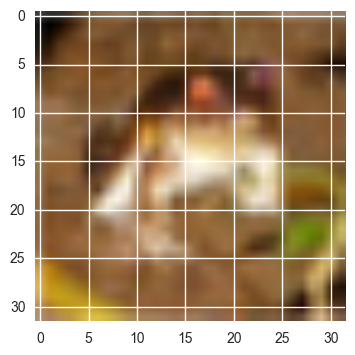

In [4]:
imgplot = plt.imshow(images[0])

In [5]:
# convert to luminance, thanks http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

for i in range(0, len(images)):
    images[i] = rgb2gray(images[i])

In [6]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


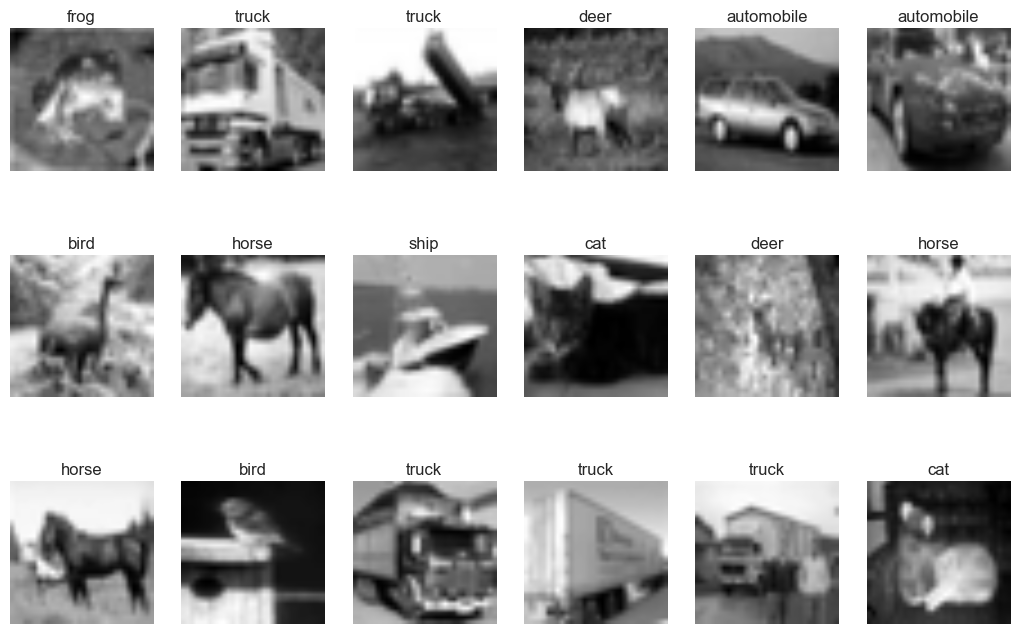

In [7]:
plot_gallery(images, labels, 32, 32) # defaults to showing a 3 by 6 subset of the faces

In [8]:
# Linearization
img_concat = []
for image in images: 
    img_concat.append(np.concatenate(image))

In [13]:
# img_concat_arr = np.array(img_concat)
print(len(img_concat))
print(np.array(img_concat[0:50000]).shape)

50000
(50000, 1024)


In [14]:
# get some of the specifics of the dataset
# y = lfw_people.target
X = np.array(img_concat[0:5000]) 
names = labels[0:5000]

n_samples, n_features = X.shape
h, w = 32, 32
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {}by{}".format(h,w))
print (125*94) # the size of the images are the size of the feature vectors

n_samples: 5000
n_features: 1024
n_classes: 5000
Original Image Sizes 32by32
11750


## Full PCA

In [29]:
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenobjects from %d objects" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenobjects from 5000 objects
CPU times: user 2.46 s, sys: 96.8 ms, total: 2.56 s
Wall time: 1.43 s


In [30]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [ ]:
plot_explained_variance(pca)

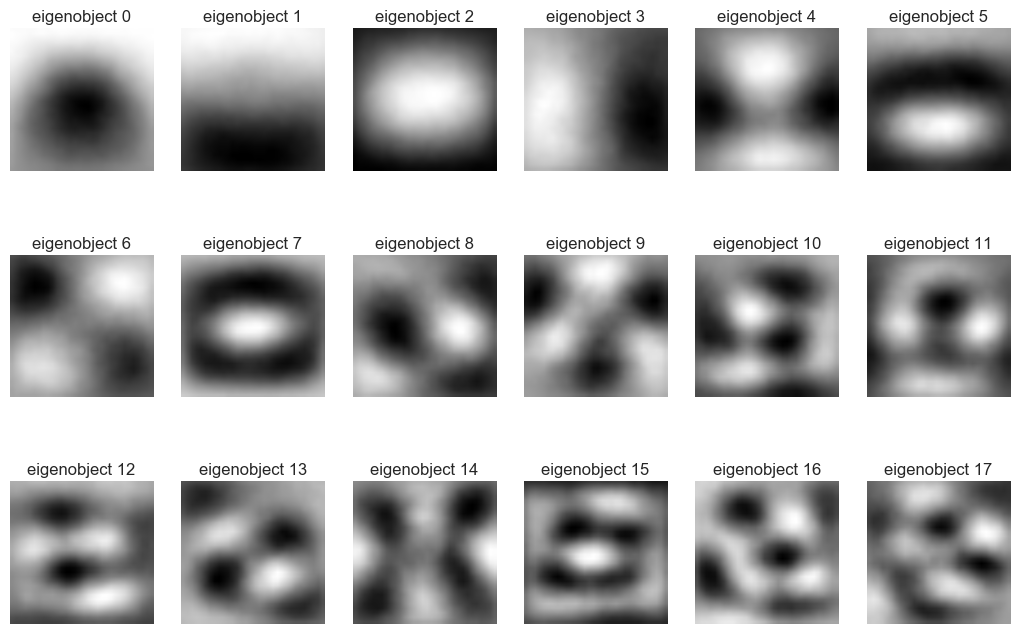

In [32]:
eigen_titles = ["eigenobject %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigen_titles, h, w)

In [33]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

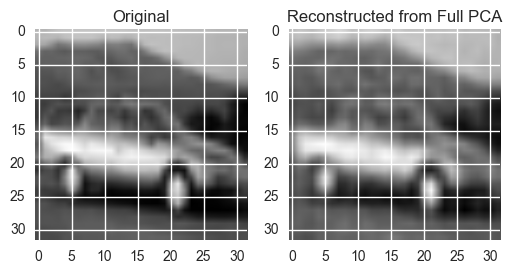

In [34]:
idx_to_reconstruct = 4    
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct])

plt.subplot(1,2,1)
plt.imshow(X[4].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')

## Randomized PCA

In [35]:
from sklearn.decomposition import RandomizedPCA

n_components = 300
print ("Extracting the top %d eigenvalues from %d objects" % (
    n_components, X.shape[0]))

rpca = RandomizedPCA(n_components=n_components)
%time rpca.fit(X)
eigenfaces = rpca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenvalues from 5000 objects
CPU times: user 1.44 s, sys: 90.5 ms, total: 1.53 s
Wall time: 850 ms


In [ ]:
plot_explained_variance(rpca)

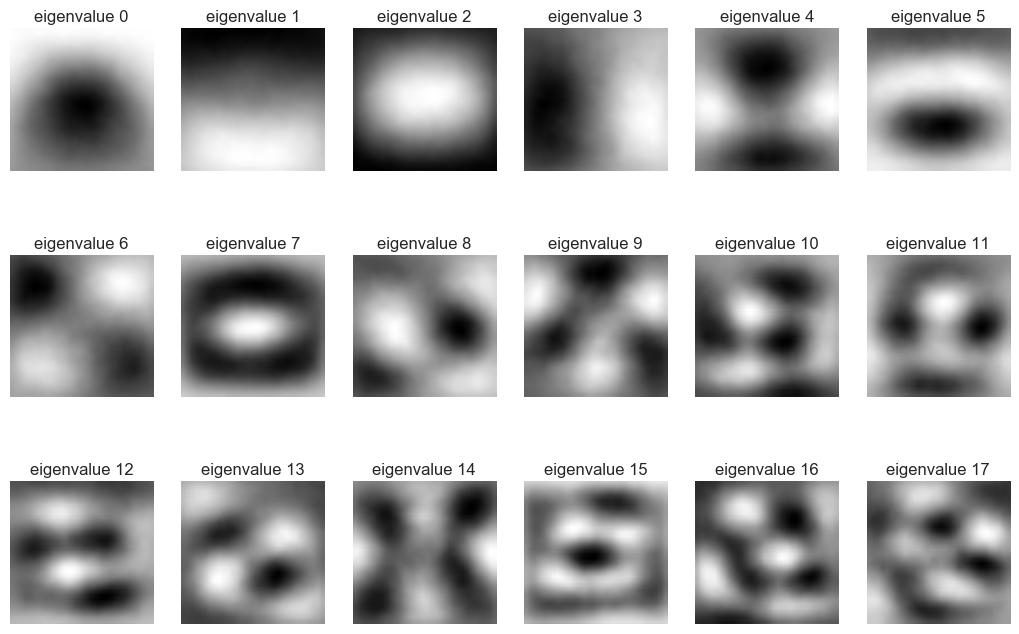

In [37]:
eigenface_titles = ["eigenvalue %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

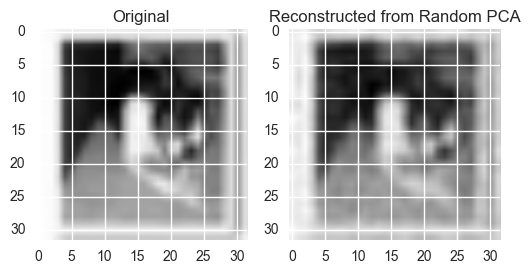

In [38]:
from skimage.io import imshow
idx_to_reconstruct = int(np.random.rand(1)*len(X))
low_dimensional_representation, reconstructed_image = reconstruct_image(rpca,X[idx_to_reconstruct])
plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Random PCA')


## Kernel PCA- Nonlinear Reduction

In [39]:
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(X)


Extracting the top 300 eigenfaces from 5000 faces
CPU times: user 35.4 s, sys: 886 ms, total: 36.2 s
Wall time: 20.2 s


KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=300,
     remove_zero_eig=False, tol=0)

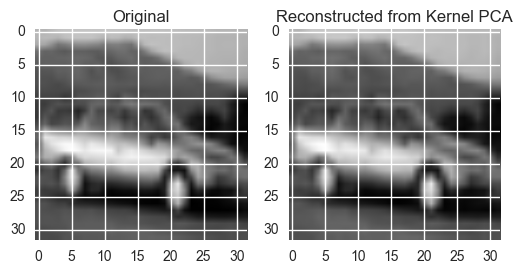

In [40]:
idx_to_reconstruct = 4    
low_dimensional_representation, reconstructed_image = reconstruct_image(kpca,X[idx_to_reconstruct])

plt.subplot(1,2,1)
plt.imshow(X[4].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Kernel PCA')

In [ ]:
plot_explained_variance(kpca)

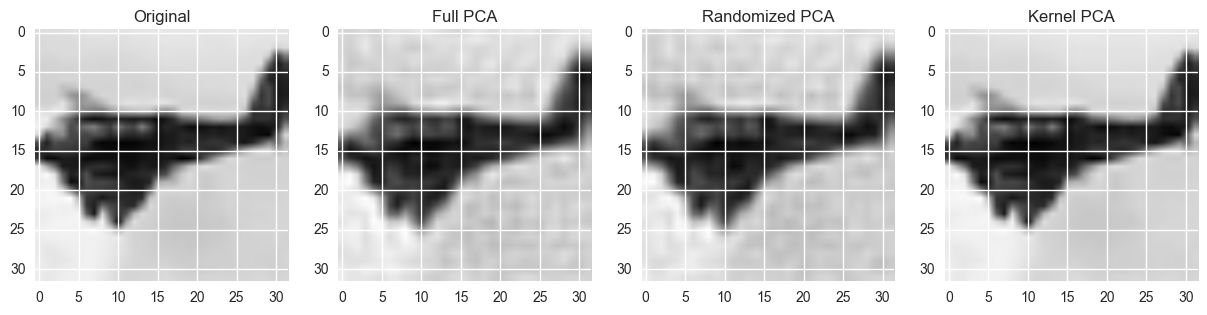

In [41]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

## Daisy Feature Extraction

In [74]:
target = pd.DataFrame(labels[:5000], np.array(range(0, 5000)))

In [79]:
target = {'labels': labels[:5000], 'id': np.array(range(0, 5000))}

In [80]:
target = pd.DataFrame(target)

In [98]:
target[target['labels']=='frog'].id.values

array([   0,   19,   22,   23,   25,   72,   95,  103,  104,  117,  124,
        125,  132,  143,  151,  154,  164,  187,  200,  204,  209,  210,
        224,  228,  231,  232,  234,  235,  242,  243,  245,  248,  249,
        286,  292,  298,  313,  326,  327,  347,  350,  351,  355,  361,
        368,  387,  409,  437,  451,  452,  464,  473,  488,  525,  529,
        532,  552,  556,  571,  587,  588,  591,  619,  620,  625,  633,
        640,  645,  651,  655,  667,  680,  682,  692,  710,  718,  720,
        721,  728,  738,  745,  755,  770,  781,  807,  818,  819,  836,
        837,  838,  854,  862,  863,  896,  899,  903,  914,  920,  921,
        923,  929,  931,  935,  937,  960,  961,  985, 1013, 1016, 1017,
       1023, 1027, 1031, 1035, 1038, 1047, 1051, 1053, 1063, 1085, 1101,
       1126, 1131, 1132, 1154, 1155, 1159, 1161, 1175, 1176, 1191, 1192,
       1194, 1210, 1220, 1222, 1228, 1237, 1246, 1248, 1259, 1317, 1318,
       1327, 1342, 1360, 1362, 1367, 1371, 1374, 13

In [90]:
target.head()

,id,labels
0,0,frog
1,1,truck
2,2,truck
3,3,deer
4,4,automobile
